In [5]:
pip install tf-nightly-cpu

/Users/piyushuprety/.zshenv:1: bad assignment
ERROR: Could not find a version that satisfies the requirement tf-nightly-cpu (from versions: none)
ERROR: No matching distribution found for tf-nightly-cpu
Note: you may need to restart the kernel to use updated packages.


In [6]:
import tensorflow as tf
from keras.optimizers import RMSprop
tf.config.experimental.set_visible_devices([], 'GPU')
from sample_models import *
# import function for training acoustic model
from train_utils import train_model
from jiwer import wer
from jiwer import cer

Model Train on all voices

In [7]:
Cumulative_model = final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200) 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 13)]        0         
                                                                 
 conv1d (Conv1D)             (None, None, 200)         28800     
                                                                 
 bn_conv_1d (BatchNormalizat  (None, None, 200)        800       
 ion)                                                            
                                                                 
 bidir_rnn (Bidirectional)   (None, None, 400)         482400    
                                                                 
 batchnorm_rnn (BatchNormali  (None, None, 400)        1600      
 zation)                                                         
                                                                 
 dropout (Dropout)           (None, None, 400)         0   

In [8]:
train_model(input_to_softmax=Cumulative_model,
            pickle_path='Cumulative_model.pickle',
            save_model_path='Cumulative_model.h5',
            epochs=10,
            train_json="train_corpus_c.json",
            valid_json="valid_corpus_c.json",
            minibatch_size=20,
            spectrogram=False)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 132.4984

ValueError: Unable to create dataset (name already exists)

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

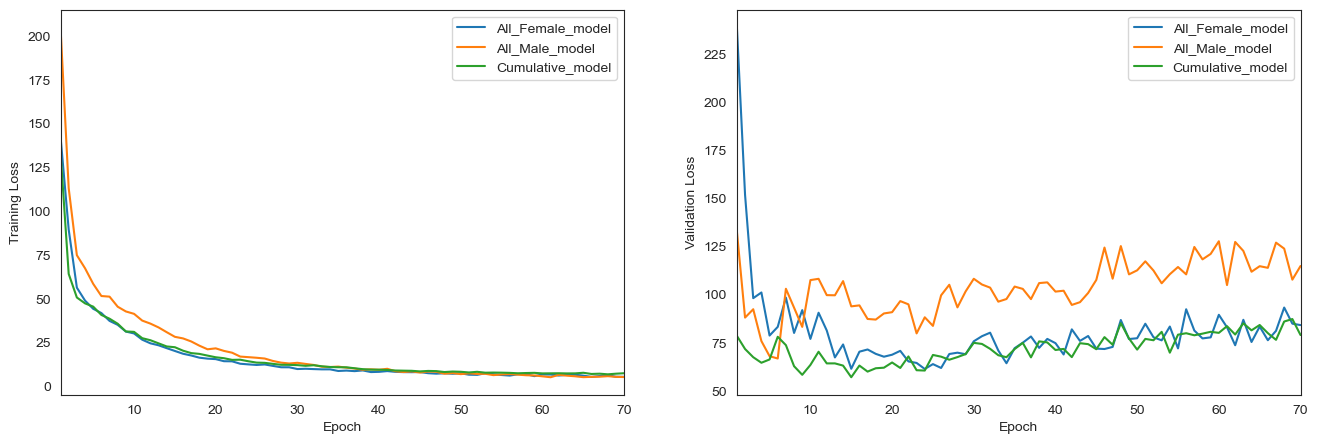

In [71]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()



<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [72]:
ver=[]

In [73]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition,train_json,valid_json, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """

    # load the train and test data
    data_gen = AudioGenerator(spectrogram=False)
    data_gen.load_train_data(train_json)
    data_gen.load_validation_data(valid_json)
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    #print('-'*80)
    ver.append(transcr)
    #Audio(audio_path)
    print(str(index) + ' True transcription:\n'+ transcr+"\n")
    #print('-'*80)
    #print('Predicted transcription:')
    predlist = []
    for i in int_sequence_to_text(pred_ints):
        if(i == '<SPACE>' or i == "_"):
            predlist.append(" ")
        else:
            predlist.append(i)
    
    str1 =""
    str1=''.join(predlist)
    return (str1)
    
    
    

Cumulative model predicting all voices

In [74]:
finallist=[]
for i in range(0,100):
    finallist.append(get_predictions(index=i, 
                partition='validation',
                train_json="train_corpus_c.json",
                valid_json="valid_corpus_c.json",
                input_to_softmax=Cumulative_model, 
                model_path='results/Cumulative_model.h5'))


1/1 [==============================] - 0s 38ms/step
0 True transcription:
thank you sir

1/1 [==============================] - 0s 21ms/step
1 True transcription:
good morning madam

1/1 [==============================] - 0s 28ms/step
2 True transcription:
you are leaving now

1/1 [==============================] - 0s 56ms/step
3 True transcription:
the restaurant is open

1/1 [==============================] - 0s 31ms/step
4 True transcription:
how are you

1/1 [==============================] - 0s 29ms/step
5 True transcription:
thank you for the rose

1/1 [==============================] - 0s 24ms/step
6 True transcription:
welcome to the show

1/1 [==============================] - 0s 21ms/step
7 True transcription:
hello dear

1/1 [==============================] - 0s 31ms/step
8 True transcription:
who paid for the dinner

1/1 [==============================] - 0s 28ms/step
9 True transcription:
the gate is open

1/1 [==============================] - 0s 29ms/step
10 True transcr

In [75]:
for i in range(0,100):   
    print(finallist[i])

tnk os l                                                                                     
od mornime m do                                                                                    
oure gii nont                                                                                   
the sthn theso                                                                                              
howlyouf                                                                                      
thank o for theiorrs                                                                                        
helco bo heshou                                                                                         
hello dear                                                                  
ho pez for thed ndc                                                                                                
hhyt ooisopn                                                                            
thesiis d

Cumulative model predicting male voices

In [76]:
finallist_M=[]
for i in range(0,50):
    finallist_M.append(get_predictions(index=i, 
                partition='validation',
                train_json="train_corpus_c.json",
                valid_json="valid_corpus_m.json",
                input_to_softmax=Cumulative_model, 
                model_path='results/Cumulative_model.h5'))

1/1 [==============================] - 0s 57ms/step
0 True transcription:
thank you sir

1/1 [==============================] - 0s 21ms/step
1 True transcription:
good morning madam

1/1 [==============================] - 0s 19ms/step
2 True transcription:
you are leaving now

1/1 [==============================] - 0s 24ms/step
3 True transcription:
the restaurant is open

1/1 [==============================] - 0s 17ms/step
4 True transcription:
how are you

1/1 [==============================] - 0s 18ms/step
5 True transcription:
thank you for the rose

1/1 [==============================] - 0s 28ms/step
6 True transcription:
welcome to the show

1/1 [==============================] - 0s 17ms/step
7 True transcription:
hello dear

1/1 [==============================] - 0s 20ms/step
8 True transcription:
who paid for the dinner

1/1 [==============================] - 0s 19ms/step
9 True transcription:
the gate is open

1/1 [==============================] - 0s 20ms/step
10 True transcr

In [77]:
for i in range(0,50):   
    print(finallist_M[i])

hin ey so                        
od morig maomel                               
wyou lolerli mdour                                  
toeie tarnte opth                                            
 you                           
 eyo forheo s                                 
gio moehesho                              
hlo e you                  
 pee for tee doedo                                
dleat you do pon                                    
os glre llou                                      
whmyoa apei                               
ly ecaia a me                                    
hinde you for ou fhe pdres ponthe                                         
you echoen meedteyorind t morni g                                                                
teie dhe e leis mie                                                             
t mgaiedoelo sa                                                
wm you aw aos  tee                                                             
 born cs

Cumulative model predicting female voices

In [78]:
finallist_F=[]
for i in range(0,50):
    finallist_F.append(get_predictions(index=i, 
                partition='validation',
                train_json="train_corpus_c.json",
                valid_json="valid_corpus_f.json",
                input_to_softmax=Cumulative_model, 
                model_path='results/Cumulative_model.h5'))

1/1 [==============================] - 0s 30ms/step
0 True transcription:
thank you sir

1/1 [==============================] - 0s 25ms/step
1 True transcription:
good morning madam

1/1 [==============================] - 0s 26ms/step
2 True transcription:
you are leaving now

1/1 [==============================] - 0s 27ms/step
3 True transcription:
the restaurant is open

1/1 [==============================] - 0s 26ms/step
4 True transcription:
how are you

1/1 [==============================] - 0s 29ms/step
5 True transcription:
thank you for the rose

1/1 [==============================] - 0s 23ms/step
6 True transcription:
welcome to the show

1/1 [==============================] - 0s 22ms/step
7 True transcription:
hello dear

1/1 [==============================] - 0s 29ms/step
8 True transcription:
who paid for the dinner

1/1 [==============================] - 0s 25ms/step
9 True transcription:
the gate is open

1/1 [==============================] - 0s 64ms/step
10 True transcr

In [79]:
for i in range(0,50):   
    print(finallist_F[i])

tnk os l                                                                                     
od mornime m do                                                                                    
oure gii nont                                                                                   
the sthn theso                                                                                              
howlyouf                                                                                      
thank o for theiorrs                                                                                        
helco bo heshou                                                                                         
hello dear                                                                  
ho pez for thed ndc                                                                                                
hhyt ooisopn                                                                            
thesiis d

## STEP 4: Calculate Error Rate

Word Error Rate of Cumulative model predicting all voices

In [80]:
Werror_Cumulative=[]
for i in range(0,100):
    Werror_Cumulative.append(wer(ver[i], finallist[i]))

In [81]:
sum=0.0;
for i in range (0,100):
    #print(i+1,end="\t")
    sum+=float(Werror_Cumulative[i])
    print(Werror_Cumulative[i])
print("AVG = ",sum/100)

1.0
1.3333333333333333
1.0
0.75
1.0
0.6
1.0
0.0
0.8
1.0
1.0
1.0
1.25
1.0
1.0
1.25
0.6666666666666666
0.8
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.6666666666666666
1.3333333333333333
0.75
1.0
1.0
0.8
1.25
1.0
1.0
1.0
1.0
0.5
0.75
0.6666666666666666
0.8571428571428571
0.75
1.6666666666666667
1.0
1.0
1.0
0.6666666666666666
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.6666666666666666
1.0
1.0
1.5
0.8
1.0
1.0
1.0
0.75
0.8333333333333334
0.8571428571428571
1.25
1.0
1.0
1.25
1.0
1.0
1.0
1.0
1.0
1.0
0.6666666666666666
1.0
0.75
1.0
0.6666666666666666
1.0
1.0
0.5
1.0
1.0
1.0
1.0
0.75
0.8333333333333334
1.0
1.0
1.0
0.8
1.25
1.0
0.6666666666666666
1.0
1.0
1.0
0.75
AVG =  0.9464761904761905


Word Error Rate of Cumulative model predicting male voices

In [82]:
Werror_Cumulative_M=[]
for i in range(0,50):
    Werror_Cumulative_M.append(wer(ver[i], finallist_M[i]))

In [83]:
sum=0.0;
for i in range (0,50):
    #print(i+1,end="\t")
    sum+=float(Werror_Cumulative_M[i])
    print(Werror_Cumulative_M[i])
print("AVG = ",sum/50)

1.0
1.0
1.0
1.0
0.6666666666666666
1.0
1.0
1.5
0.8
1.0
1.0
1.0
0.75
0.8333333333333334
0.8571428571428571
1.25
1.0
1.0
1.25
1.0
1.0
1.0
1.0
1.0
1.0
0.6666666666666666
1.0
0.75
1.0
0.6666666666666666
1.0
1.0
0.5
1.0
1.0
1.0
1.0
0.75
0.8333333333333334
1.0
1.0
1.0
0.8
1.25
1.0
0.6666666666666666
1.0
1.0
1.0
0.75
AVG =  0.9508095238095238


Word Error Rate of Cumulative model predicting female voices

In [84]:
Werror_Cumulative_F=[]
for i in range(0,50):
    Werror_Cumulative_F.append(wer(ver[i], finallist_F[i]))

In [85]:
sum=0.0;
for i in range (0,50):
    #print(i+1,end="\t")
    sum+=float(Werror_Cumulative_F[i])
    print(Werror_Cumulative_F[i])
print("AVG = ",sum/50)

1.0
1.3333333333333333
1.0
0.75
1.0
0.6
1.0
0.0
0.8
1.0
1.0
1.0
1.25
1.0
1.0
1.25
0.6666666666666666
0.8
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.6666666666666666
1.3333333333333333
0.75
1.0
1.0
0.8
1.25
1.0
1.0
1.0
1.0
0.5
0.75
0.6666666666666666
0.8571428571428571
0.75
1.6666666666666667
1.0
1.0
1.0
0.6666666666666666
1.0
1.0
1.0
1.0
AVG =  0.942142857142857


Character Error Rate of Cumulative model predicting all voices

In [86]:
Cerror_Cumulative=[]
for i in range(0,100):
    Cerror_Cumulative.append(cer(ver[i], finallist[i]))

In [87]:
sum=0.0;
for i in range (0,100):
    #print(i+1,end="\t")
    sum+=float(Cerror_Cumulative[i])
    print(Cerror_Cumulative[i])
print("AVG = ",sum/100)

0.5384615384615384
0.3888888888888889
0.5789473684210527
0.5909090909090909
0.5454545454545454
0.2727272727272727
0.3684210526315789
0.0
0.391304347826087
0.625
0.5333333333333333
0.7058823529411765
0.6111111111111112
0.5151515151515151
0.3888888888888889
0.6190476190476191
0.5
0.5
0.6666666666666666
0.76
0.8
0.7647058823529411
0.6842105263157895
0.5714285714285714
0.6666666666666666
0.23076923076923078
0.5
0.631578947368421
0.7272727272727273
0.8181818181818182
0.3181818181818182
0.7368421052631579
0.5
0.6521739130434783
0.625
0.6666666666666666
0.23529411764705882
0.5
0.5151515151515151
0.4444444444444444
0.5238095238095238
0.6538461538461539
0.5416666666666666
0.5
0.52
0.6
0.7058823529411765
0.6842105263157895
0.6571428571428571
0.6666666666666666
0.6153846153846154
0.4444444444444444
0.6842105263157895
0.5
0.7272727272727273
0.5909090909090909
0.5789473684210527
0.7
0.5652173913043478
0.6875
0.8
0.5882352941176471
0.7222222222222222
0.45454545454545453
0.4444444444444444
0.71428571

Character Error Rate of Cumulative model predicting male voices

In [88]:
Cerror_Cumulative_M=[]
for i in range(0,50):
    Cerror_Cumulative_M.append(cer(ver[i], finallist_M[i]))

In [89]:
sum=0.0;
for i in range (0,50):
    #print(i+1,end="\t")
    sum+=float(Cerror_Cumulative_M[i])
    print(Cerror_Cumulative_M[i])
print("AVG = ",sum/50)

0.6153846153846154
0.4444444444444444
0.6842105263157895
0.5
0.7272727272727273
0.5909090909090909
0.5789473684210527
0.7
0.5652173913043478
0.6875
0.8
0.5882352941176471
0.7222222222222222
0.45454545454545453
0.4444444444444444
0.7142857142857143
0.7692307692307693
0.5833333333333334
0.5833333333333334
0.64
0.4
0.7647058823529411
0.7894736842105263
0.5428571428571428
0.6666666666666666
0.23076923076923078
0.5
0.42105263157894735
0.5909090909090909
0.18181818181818182
0.45454545454545453
0.3684210526315789
0.2
0.6086956521739131
0.5
0.5333333333333333
0.4117647058823529
0.3888888888888889
0.36363636363636365
0.6666666666666666
0.5238095238095238
0.5384615384615384
0.5833333333333334
0.5833333333333334
0.68
0.4
0.5882352941176471
0.6842105263157895
0.6285714285714286
0.5555555555555556
AVG =  0.5548646378396885


Character Error Rate of Cumulative model predicting female voices

In [90]:
Cerror_Cumulative_F=[]
for i in range(0,50):
    Cerror_Cumulative_F.append(cer(ver[i], finallist_F[i]))

In [91]:
sum=0.0;
for i in range (0,50):
    #print(i+1,end="\t")
    sum+=float(Cerror_Cumulative_F[i])
    print(Cerror_Cumulative_F[i])
print("AVG = ",sum/50)

0.5384615384615384
0.3888888888888889
0.5789473684210527
0.5909090909090909
0.5454545454545454
0.2727272727272727
0.3684210526315789
0.0
0.391304347826087
0.625
0.5333333333333333
0.7058823529411765
0.6111111111111112
0.5151515151515151
0.3888888888888889
0.6190476190476191
0.5
0.5
0.6666666666666666
0.76
0.8
0.7647058823529411
0.6842105263157895
0.5714285714285714
0.6666666666666666
0.23076923076923078
0.5
0.631578947368421
0.7272727272727273
0.8181818181818182
0.3181818181818182
0.7368421052631579
0.5
0.6521739130434783
0.625
0.6666666666666666
0.23529411764705882
0.5
0.5151515151515151
0.4444444444444444
0.5238095238095238
0.6538461538461539
0.5416666666666666
0.5
0.52
0.6
0.7058823529411765
0.6842105263157895
0.6571428571428571
0.6666666666666666
AVG =  0.5548397858120702
